## Question 3: Data Mining the Bible

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import time

In [2]:
bibleoriginal = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/bible_asv.csv")
bibleoriginal.head()

,Unnamed: 0,field,Testaments,Sections,Books,Chapters,Verses,text
0,1,1001001,OT,Law,gen,gen_1,gen_1:1,In the beginning God created the heavens and t...
1,2,1001002,OT,Law,gen,gen_1,gen_1:2,And the earth was waste and void; and darkness...
2,3,1001003,OT,Law,gen,gen_1,gen_1:3,"And God said, Let there be light: and there wa..."
3,4,1001004,OT,Law,gen,gen_1,gen_1:4,"And God saw the light, that it was good: and G..."
4,5,1001005,OT,Law,gen,gen_1,gen_1:5,"And God called the light Day, and the darkness..."


## Data Preprocessing

In [3]:
bible = bibleoriginal
#drop features that are not text or book
bible = bible.drop(['field','Chapters','Verses'], axis=1)
bible['text'] = bible['text'].str.lower()
bible['text'] = bible['text'].str.replace('[^\w\s]','')
bible['text'] = bible['text'].str.replace('\d+', '')
bible['text'] = bible['text'].str.strip()
biblebooks = bible.groupby('Books').agg(' '.join)
#tf-idf
#first we create vector using only 500 words and removing useless stop words
#we just consider words that matter to the target variable (salary)
vector = TfidfVectorizer(stop_words='english', max_features=500)
data = pd.DataFrame(vector.fit_transform(biblebooks.text).toarray(), columns = vector.get_feature_names())
#print(biblebooks.shape)
#print(bibleVectorized.shape)
#data = pd.concat(biblebooks['Testements'], biblebooks['Sections'], axis=1)
#data.head()
biblebooks['Sections'] = [n.partition(' ')[0] for n in biblebooks['Sections']]
biblebooks['Testaments'] = [n.partition(' ')[0] for n in biblebooks['Testaments']]
#biblebooks = pd.concat([biblebooks['Books'], bibleVectorized], axis=1)
#print(biblebooks.shape)
#biblebooks = biblebooks.drop('text', axis=1)
#print (biblebooks.shape)
#print (data.shape)
#print(biblebooks['text'][0])


## Preliminary Visualization

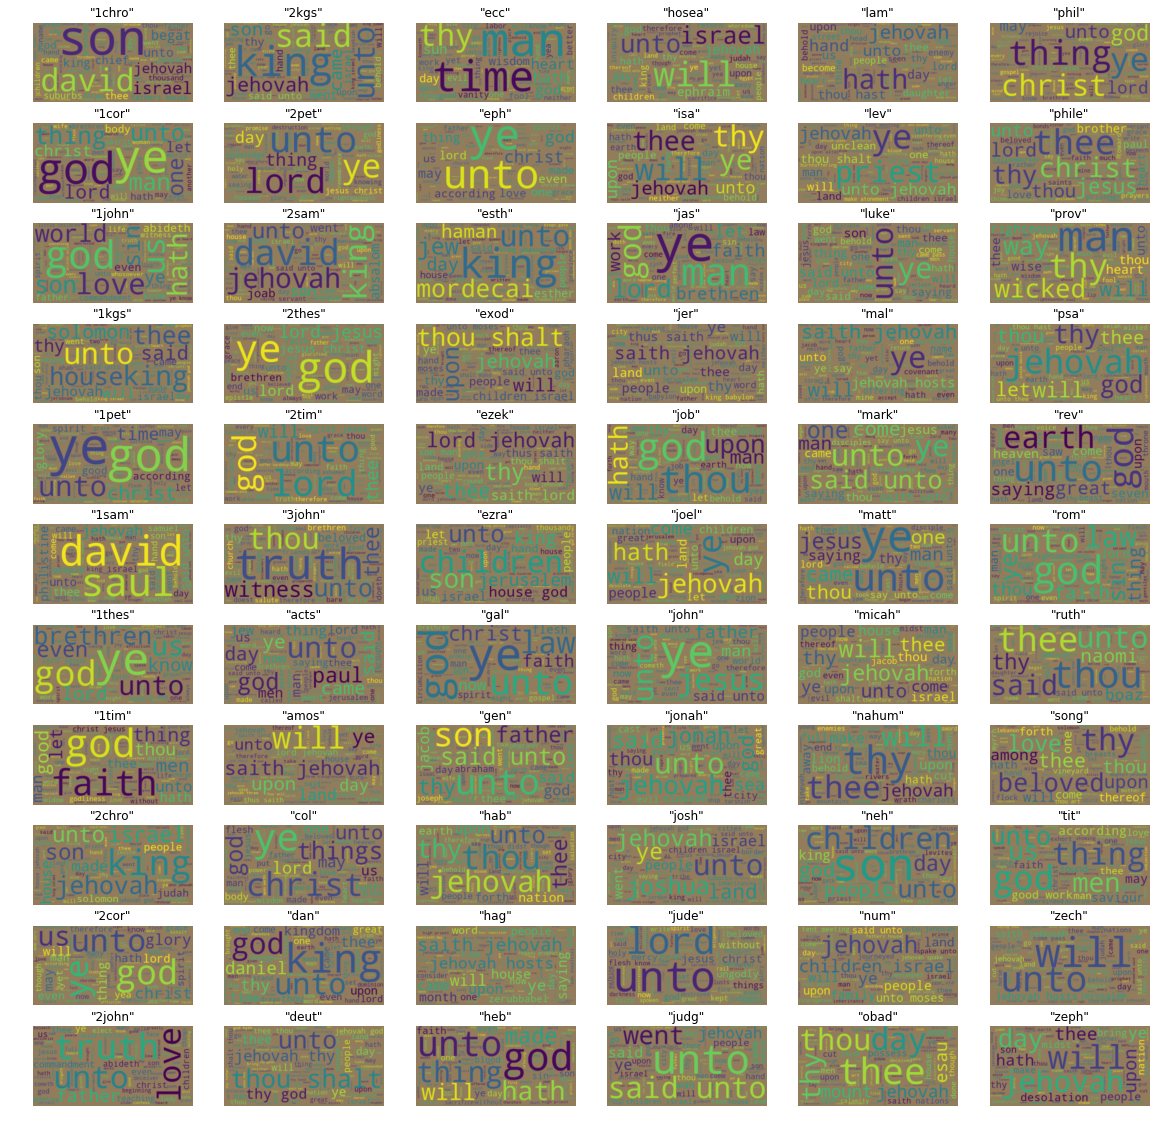

In [446]:
f, ax = plt.subplots(11, 6, figsize=(20, 20))
for a in range(11):
    for b in range(6):
        wordcloud = WordCloud(max_words=100,background_color="#927c5c").generate(biblebooks['text'][b*11+a])
        ax[a,b].imshow(wordcloud, interpolation='bilinear')
        ax[a,b].set(title='\"' + biblebooks.axes[0][b*11+a] + '\"')
        ax[a,b].axis("off")
plt.show()

## PCA Dimension Reduction

The number of principle components with the highest ratio of variance to components is 23
Using 23 components will preserve 84.41% of the data


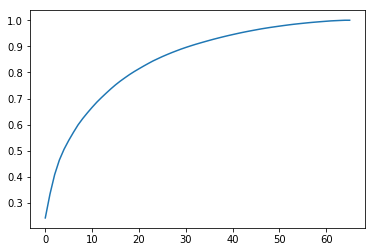

(66, 23)


In [447]:
pca = PCA().fit(data)
ratios = np.cumsum(pca.explained_variance_ratio_)
#ratios = temp/(np.arange(len(temp))+1)
maxRatioIndex = 0
for n in range(1,len(ratios)):
    if ratios[n]/(n/len(ratios)+1) > ratios[maxRatioIndex]/(maxRatioIndex/len(ratios)+1):
        maxRatioIndex = n
#ratios = sorted(ratios)
plt.plot (ratios)
print ("The number of principle components with the highest ratio of variance to components is", maxRatioIndex)
print ("Using", maxRatioIndex, "components will preserve", str(100*ratios[maxRatioIndex].round(4)) + "% of the data")
plt.show()
pca = PCA(n_components=maxRatioIndex)
pca.fit(data)
dataPCA = pca.transform(data)
print (dataPCA.shape)

In [448]:
print (biblebooks.shape)
print (data.shape)
bibledata = biblebooks
for n , columnLabel in enumerate(data.axes[1].tolist()):
    bibledata[columnLabel] = data[columnLabel].tolist()
print (bibledata.shape)

(66, 3)
(66, 500)
(66, 503)


## KMeans Clustering

In [449]:
# first find optimal number of clusters using silhouette scores
silhouetteScores = []
for numClusters in range(3,50):
    kmeans = KMeans(n_clusters=numClusters, random_state=int(time.time()))
    pred = kmeans.fit_predict(dataPCA)
    silhouetteScores.append([silhouette_score(dataPCA, pred),numClusters])
kmeansOptimal = sorted(silhouetteScores)[-1][1]
print ("The optimal number of clusters according to silhouette scores is", optimal)
plt.figure(figsize=(10,10))
kmeans = KMeans(n_clusters=kmeansOptimal, random_state=int(time.time())).fit(dataPCA)
kmeansLabels = kmeans.predict(dataPCA)
kmeans = KMeans(n_clusters=2, random_state=int(time.time())).fit(dataPCA)
kmeansLabels2 = kmeans.predict(dataPCA)

The optimal number of clusters according to silhouette scores is 3


<Figure size 720x720 with 0 Axes>

## DBSCAN Clustering

In [450]:
# first find optimal number of clusters using silhouette scores
silhouetteScores = []
for numClusters in range(3,50):
    db = DBSCAN().fit(dataPCA)
    pred = db.labels_
    silhouetteScores.append([silhouette_score(dataPCA, pred),numClusters])
optimal = sorted(silhouetteScores)[-1][1]
print ("The optimal number of clusters according to silhouette scores is", optimal)
plt.figure(figsize=(10,10))
db = DBSCAN().fit(dataPCA)
dbLabels = db.labels_

The optimal number of clusters according to silhouette scores is 49


<Figure size 720x720 with 0 Axes>

## Agglomerative Clustering

In [451]:
# first find optimal number of clusters using silhouette scores
silhouetteScores = []
for numClusters in range(3,50):
    agglo = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto', connectivity=None, linkage='ward', memory=None, n_clusters=numClusters, pooling_func='deprecated')
    pred = agglo.fit_predict(dataPCA)
    silhouetteScores.append([silhouette_score(dataPCA, pred),numClusters])
aggloOptimal = sorted(silhouetteScores)[-1][1]
print ("The optimal number of clusters according to silhouette scores is", optimal)
plt.figure(figsize=(10,10))
agglo = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto', connectivity=None, linkage='ward', memory=None, n_clusters=aggloOptimal, pooling_func='deprecated').fit(dataPCA)
aggloLabels = agglo.labels_
agglo = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto', connectivity=None, linkage='ward', memory=None, n_clusters=2, pooling_func='deprecated').fit(dataPCA)
aggloLabels2 = agglo.labels_

The optimal number of clusters according to silhouette scores is 49


<Figure size 720x720 with 0 Axes>

## Spectral Clustering

In [452]:
# first find optimal number of clusters using silhouette scores
silhouetteScores = []
for numClusters in range(3,50):
    spectral = SpectralClustering(n_clusters=numClusters, affinity='nearest_neighbors', assign_labels='kmeans')
    pred = spectral.fit_predict(dataPCA)
    silhouetteScores.append([silhouette_score(data, pred),numClusters])
spectralOptimal = sorted(silhouetteScores)[-1][1]
print ("The optimal number of clusters according to silhouette scores is", optimal)
plt.figure(figsize=(10,10))
spectral = SpectralClustering(n_clusters=spectralOptimal, affinity='nearest_neighbors', assign_labels='kmeans').fit(dataPCA)
spectralLabels = spectral.labels_
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans').fit(dataPCA)
spectralLabels2 = spectral.labels_

The optimal number of clusters according to silhouette scores is 49


<Figure size 720x720 with 0 Axes>

## Cluster Visualization

In [453]:
sections = {m:(n*100+100) for n, m in enumerate(biblebooks['Sections'].unique())}
bibledata['kmeansLabels'] = kmeansLabels
bibledata['kmeansLabels2'] = kmeansLabels2
bibledata['dbLabels'] = dbLabels
bibledata['aggloLabels'] = aggloLabels
bibledata['aggloLabels2'] = aggloLabels2
bibledata['spectralLabels'] = spectralLabels
bibledata['spectralLabels2'] = spectralLabels2
cat = []
for n, row in biblebooks.iterrows():
    cat.append(row['Testaments'] == 'OT')
bibledataOT = bibledata.loc[cat]
bibledataNT = bibledata.loc[[not b for b in cat]]

In [454]:
dataPCAot = []
dataPCAnt = []
for n, row in enumerate(dataPCA):
    if cat[n]:
        dataPCAot.append(row.tolist())
    else:
        dataPCAnt.append(row.tolist())
dataPCAot = np.array(dataPCAot)
dataPCAnt = np.array(dataPCAnt)
print (dataPCAot[:,0])
#dataPCAot.append()
#dataPCAnt.append()

[-0.2204052  -0.36812313 -0.25345078 -0.39093024 -0.3844595  -0.27288413
 -0.4052321  -0.18998666 -0.35336041 -0.0261151  -0.091264   -0.35951996
 -0.39425426 -0.12968629 -0.19564554 -0.32009854 -0.3220272  -0.33534226
 -0.40144036 -0.43845658 -0.15475442 -0.29569417 -0.28813132 -0.26574108
 -0.28901246 -0.22462511 -0.2962628  -0.25427615 -0.37703264 -0.36632662
 -0.11432022 -0.33186227 -0.33386044 -0.22083272 -0.32280445 -0.24831119
 -0.09616115 -0.43922101 -0.44413487]


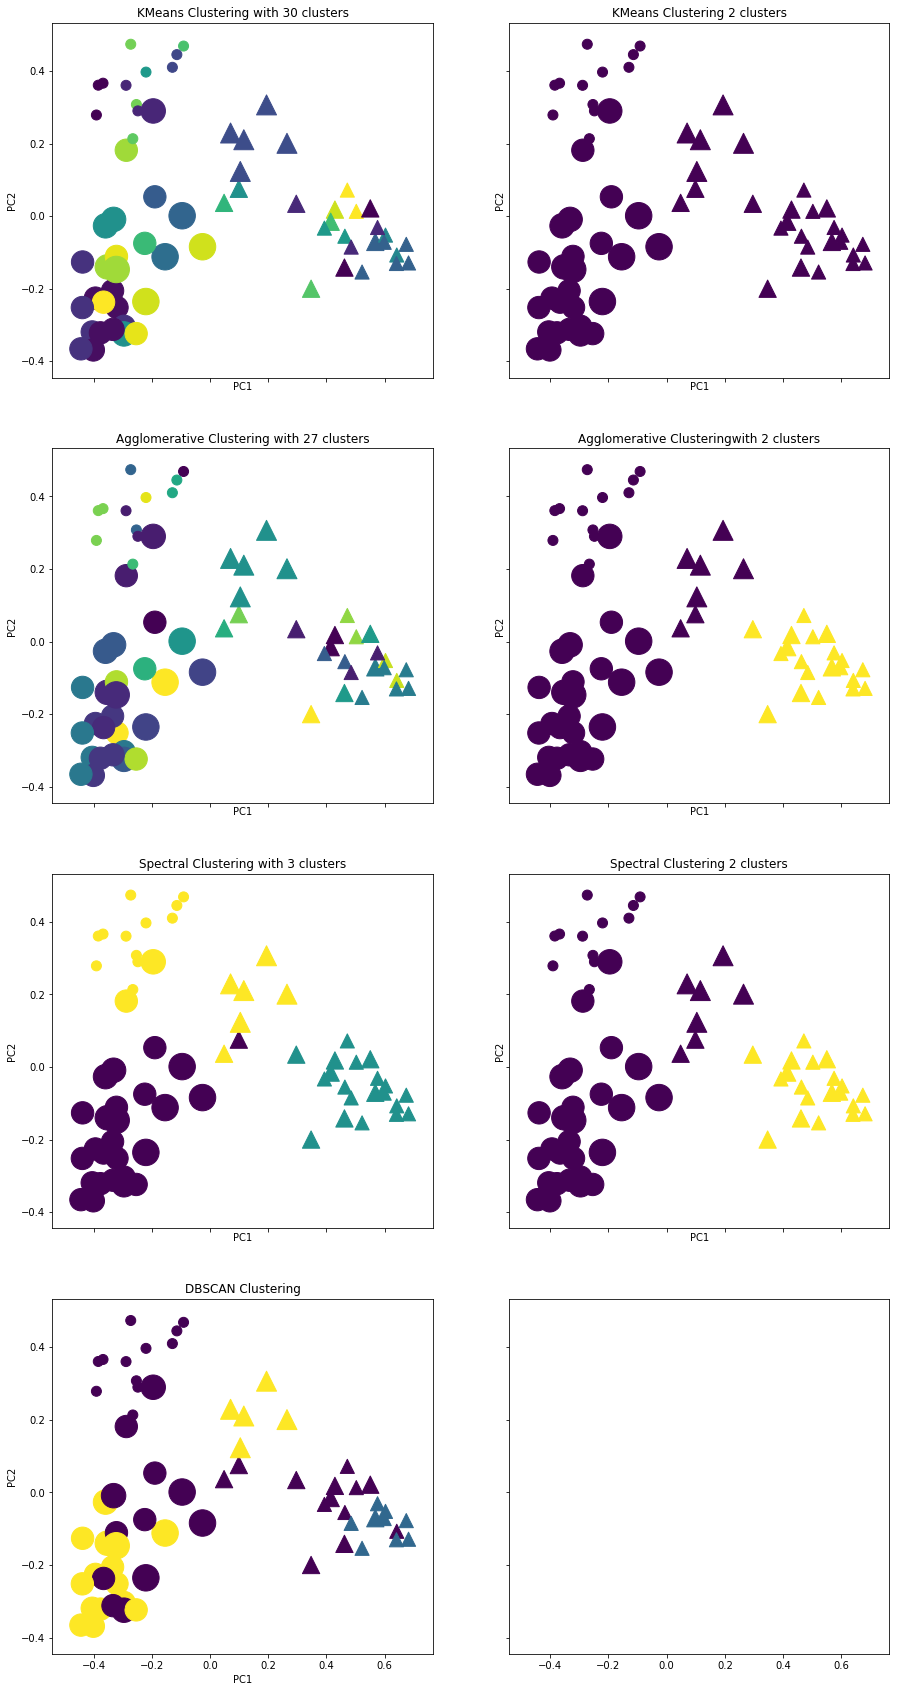

In [455]:
fig, ax = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(15,30))
ax[0,0].scatter(dataPCAot[:, 0], dataPCAot[:, 1], c=bibledataOT['kmeansLabels'], marker='o', s=[sections[n] for n in bibledataOT['Sections'].tolist()], cmap='viridis')
ax[0,0].scatter(dataPCAnt[:, 0], dataPCAnt[:, 1], c=bibledataNT['kmeansLabels'], marker='^', s=[sections[n] for n in bibledataNT['Sections'].tolist()], cmap='viridis')
ax[0,0].set(xlabel='PC1', ylabel='PC2', title='KMeans Clustering with ' + str(kmeansOptimal) + ' clusters')
ax[0,1].scatter(dataPCAot[:, 0], dataPCAot[:, 1], c=bibledataOT['kmeansLabels2'], marker='o', s=[sections[n] for n in bibledataOT['Sections'].tolist()], cmap='viridis')
ax[0,1].scatter(dataPCAnt[:, 0], dataPCAnt[:, 1], c=bibledataNT['kmeansLabels2'], marker='^', s=[sections[n] for n in bibledataNT['Sections'].tolist()], cmap='viridis')
ax[0,1].set(xlabel='PC1', ylabel='PC2', title='KMeans Clustering 2 clusters')
ax[1,0].scatter(dataPCAot[:, 0], dataPCAot[:, 1], c=bibledataOT['aggloLabels'], marker='o', s=[sections[n] for n in bibledataOT['Sections'].tolist()], cmap='viridis')
ax[1,0].scatter(dataPCAnt[:, 0], dataPCAnt[:, 1], c=bibledataNT['aggloLabels'], marker='^', s=[sections[n] for n in bibledataNT['Sections'].tolist()], cmap='viridis')
ax[1,0].set(xlabel='PC1', ylabel='PC2', title='Agglomerative Clustering with ' + str(aggloOptimal) + ' clusters')
ax[1,1].scatter(dataPCAot[:, 0], dataPCAot[:, 1], c=bibledataOT['aggloLabels2'], marker='o', s=[sections[n] for n in bibledataOT['Sections'].tolist()], cmap='viridis')
ax[1,1].scatter(dataPCAnt[:, 0], dataPCAnt[:, 1], c=bibledataNT['aggloLabels2'], marker='^', s=[sections[n] for n in bibledataNT['Sections'].tolist()], cmap='viridis')
ax[1,1].set(xlabel='PC1', ylabel='PC2', title='Agglomerative Clusteringwith 2 clusters')
ax[2,0].scatter(dataPCAot[:, 0], dataPCAot[:, 1], c=bibledataOT['spectralLabels'], marker='o', s=[sections[n] for n in bibledataOT['Sections'].tolist()], cmap='viridis')
ax[2,0].scatter(dataPCAnt[:, 0], dataPCAnt[:, 1], c=bibledataNT['spectralLabels'], marker='^', s=[sections[n] for n in bibledataNT['Sections'].tolist()], cmap='viridis')
ax[2,0].set(xlabel='PC1', ylabel='PC2', title='Spectral Clustering with ' + str(spectralOptimal) + ' clusters')
ax[2,1].scatter(dataPCAot[:, 0], dataPCAot[:, 1], c=bibledataOT['spectralLabels2'], marker='o', s=[sections[n] for n in bibledataOT['Sections'].tolist()], cmap='viridis')
ax[2,1].scatter(dataPCAnt[:, 0], dataPCAnt[:, 1], c=bibledataNT['spectralLabels2'], marker='^', s=[sections[n] for n in bibledataNT['Sections'].tolist()], cmap='viridis')
ax[2,1].set(xlabel='PC1', ylabel='PC2', title='Spectral Clustering 2 clusters')
ax[3,0].scatter(dataPCAot[:, 0], dataPCAot[:, 1], c=bibledataOT['dbLabels'], marker='o', s=[sections[n] for n in bibledataOT['Sections'].tolist()], cmap='viridis')
ax[3,0].scatter(dataPCAnt[:, 0], dataPCAnt[:, 1], c=bibledataNT['dbLabels'], marker='^', s=[sections[n] for n in bibledataNT['Sections'].tolist()], cmap='viridis')
ax[3,0].set(xlabel='PC1', ylabel='PC2', title='DBSCAN Clustering')
plt.show()

## Conclusion

A. What is the optimal number of clusters of these 66 Books? Find these clusters and describe them. Are you surprised at your finding? Why/Why not? Graph and color your clusters (probably on the first two PC's). On the graph, show your clusters in colors, the Testaments in plot symbols, and the Sections in sizes.

    answer A Kmeans with optimal number of clusters 3 found to be more reliable in testing. yes I was surprised by findings as I thought that there must be 66 different clusters but It isn't.
    


B. How would Association Analyses help to reveal characteristic word clusters? Produce word clouds for the top 10 words clusters with the top 100 most frquent words. Describe these word clusters, and what they are telling you about the Bible. How do these top 10 words clouds represent the 2 Testaments and the 7 Sections?

    answer B It will help by comparing the most frequently words occured together and from which clusters they belong as for example from the word cloud which is generated having top 100 words from each section and each testaments which consists of most frequently word used in old and new testaments like son,david, king etc.

C. How would Seriation Analyses help to reveal the structure of these 66 Books?

    Seriation will put the books in order based on patters in the data. I don't think the books would be put in the same order as in the bible, because this order is fairly arbitrary. It's more likely that the seriation analyses will put the books in order of complexity, or writing style.